Classifying Political News Media Text with Natural Language Processing
===

*Connor Foley,* Data Science Immersive, General Assembly NYC, July 2018
___

**Purpose**

In 2018, I don't think I need to remind anyone of the current news media landscape in the United States. Needless to say, the media culture is extremely polarized and the societal effects of how people source their information is becoming increasingly evident. It hasn’t always been this way, and it is important to be able to know what kind of source a piece of political news text is coming from before deciding what to do with it. Political Science is often defined as the study of power. In the era of Trump, the power of language is increasingly relevant and important. **In this project, I aim to build a model that predicts whether or not political media text is right wing or not right wing.** I could have chosen to call these labels “right” and “left”, but I chose more of a "one vs. rest" terminology to reflect the fact that the political spectrum isn't as simple as Right and Left. There is more to say about far right news media entering the mainstream, but we can save that for a rainy day. Furthermore, this project is a stepping stone to future projects using multi class targets that more accurately reflect the kinds of political news media that are out there. Likewise, it is a stepping stone to more intimidating and complex projects that tackle social media language as well. 

In [81]:
import pandas as pd
import numpy as np
# SciKitLearn Imports
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression, PassiveAggressiveClassifier, SGDClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.decomposition import TruncatedSVD
# NLP Tools
import nltk
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
# Plotting Imports
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

%matplotlib inline

np.random.seed(42)

import warnings
warnings.simplefilter("ignore")

<a id="contents"></a>
## Contents

- [Load Data](#load-data)
- [Clean Data](#clean-data)
- [NLP Feature Engineering](#feature-engineering)
- [Explore Data](#explore-data)
- [Modeling](#modeling)
    - [Text Features Only](#text-only)
    - [Numerical Features Only](#num-only)
    - [Pipeline: Combine Text and Numerical Features](#pipeline)
- [Evaluate Model](#eval-model)
- [Answer Question](#answer-question)
- [Next Steps](#next-steps)

<a id="load-data"></a>
## Load Data
[Return to Index](#contents)

Here I load in all of the individual .csv files I had created by scraping article information from News API as well as from RSS feeds using Beautiful Soup. The notebooks for this data collection process can be found in the main folder of this repository. 

I collected data for 36,854 unique articles from a variety of right wing and not right wing sources. The features collected were title, description, date posted, url, author, and source. Choosing obviously partisan sources, I labeled whether they are right wing or not based on the source. Therefore, since I would only be starting with title and description as features, a challenge I faced is making sure that any giveaway of the source is removed from an article’s text features. 

In [402]:
bb = pd.read_csv('./datasets/jun20_bb_posts.csv', )
cnn = pd.read_csv('./datasets/jun20_cnn_posts.csv')
fox = pd.read_csv('./datasets/jun20_fox_posts.csv')
fox2 = pd.read_csv('./datasets/fox_posts_jun26.csv')
fox3 = pd.read_csv('./datasets/fox_posts_jun29.csv')
nr = pd.read_csv('./datasets/jun20_nr_posts.csv')
nr2 = pd.read_csv('./datasets/jun29_nr_posts.csv')
vice = pd.read_csv('./datasets/jun20_vice_posts.csv')
dem = pd.read_csv('./datasets/jun21_demnow_posts.csv')
dem2 = pd.read_csv('./datasets/jun22_demnow_posts.csv')
dem3 = pd.read_csv('./datasets/jun23_demnow_posts.csv')
dem4 = pd.read_csv('./datasets/jun24_demnow_posts.csv')
dem5 = pd.read_csv('./datasets/jun25_demnow_posts.csv')
dem6 = pd.read_csv('./datasets/jun26_demnow_posts.csv')
dem7 = pd.read_csv('./datasets/jun29_demnow_posts.csv')
inwa = pd.read_csv('./datasets/june20infowars.csv')
inwa2 = pd.read_csv('./datasets/june21infowars.csv')
inwa3 = pd.read_csv('./datasets/june22infowars.csv')
inwa4 = pd.read_csv('./datasets/june23infowars.csv')
inwa5 = pd.read_csv('./datasets/june24infowars.csv')
inwa6 = pd.read_csv('./datasets/june25infowars.csv')
inwa7 = pd.read_csv('./datasets/june26infowars.csv')
inwa8 = pd.read_csv('./datasets/june29infowars.csv')
msnbc = pd.read_csv('./datasets/jun26_msnbc_posts.csv')
huff = pd.read_csv('./datasets/jun_24_huff_posts.csv')

In [403]:
# Assign the right wing target
bb['yes_right'] = 1
cnn['yes_right'] = 0
fox['yes_right'] = 1
fox2['yes_right'] = 1
fox3['yes_right'] = 1
nr['yes_right'] = 1
nr2['yes_right'] = 1
vice['yes_right'] = 0
dem['yes_right'] = 0
dem2['yes_right'] = 0
dem3['yes_right'] = 0
dem4['yes_right'] = 0
dem5['yes_right'] = 0
dem6['yes_right'] = 0
dem7['yes_right'] = 0
inwa['yes_right'] = 1
inwa2['yes_right'] = 1
inwa3['yes_right'] = 1
inwa4['yes_right'] = 1
inwa5['yes_right'] = 1
inwa6['yes_right'] = 1
inwa7['yes_right'] = 1
inwa8['yes_right'] = 1
msnbc['yes_right'] = 0
huff['yes_right'] = 0

In [404]:
text = pd.concat([bb, cnn, fox, fox2, fox3, nr, nr2, vice, dem,
                  dem2, dem3, dem4, dem5, dem6, dem7, inwa,
                  inwa2, inwa3, inwa4, inwa5, inwa6, inwa7, inwa8,
                  msnbc, huff])

<a id="clean-data"></a>
### Clean Data
[Return to Index](#contents)

In [405]:
text.drop(['Unnamed: 0', 'category', 'urlToImage'], axis=1, inplace=True)

In [406]:
# Check for missing values
text.isna().sum()

author         9466
description      69
publishedAt       0
source            0
title             1
url               0
yes_right         0
dtype: int64

In [407]:
no_desc = text.description.isna()

In [408]:
# Dropped all rows with missing text, as that is all I will be using as features
text.dropna(subset=['description','title'], inplace=True)

In [409]:
text.isna().sum()

author         9408
description       0
publishedAt       0
source            0
title             0
url               0
yes_right         0
dtype: int64

In [410]:
text.fillna('no_author', inplace=True)

In [411]:
text.shape

(50578, 7)

In [412]:
len(text.url.unique())

36854

In [413]:
text.drop_duplicates('url', inplace=True)

In [414]:
text.isna().sum().sum() # No more NaNs

0

In [415]:
text.shape

(36854, 7)

In [416]:
text.reset_index(drop=True, inplace=True)

In [40]:
text.yes_right.value_counts()[0]/len(text.yes_right) 
# Baseline accuracy is 53.5%, almost a 50/50 split in target
# There are a bit more not right sources than right

0.53470450968687255

In [419]:
text.source.value_counts()
# Democracy Now and Infowars don't produce quite as much content...

fox news           6381
national review    5348
huffington post    4950
msnbc              4950
vice news          4949
breitbart          4948
cnn                4776
infowars            471
democracy now        81
Name: source, dtype: int64

In [420]:
source_dict = {'breitbart': "Breitbart", 'cnn': "CNN", 'fox news': "Fox News",
               'national review': "National Review", 'vice news': "Vice News",
               'democracy now': "Democracy Now", 'infowars': "Infowars",
               'msnbc': "MSNBC", 'huffington post': "Huffington Post"}

text['source'] = text['source'].map(source_dict)

In [424]:
text['author'] = [a.replace(', CNN', '') for a in text['author']]

**Removing Source Giveaways from the Title and Description**

There was a multi-step process to remove source giveaways from the articles' text features. Here I create a function to use in the `.apply()` function to remove any mention of any source from all of the title and description text, as well as remove that specific article's author from the text. This cleaned up a lot of source giveaways, but there was still much that slipped through the cracks.

In [422]:
def remove_source_info(row):
    sources = ['Breitbart', 'CNN', 'Fox News', 'National Review', 'Vice News',
               'Democracy Now', 'Infowars', 'MSNBC', 'Huffington Post']
    for source in sources:
        row['description'] = row['description'].replace(source, '')
        row['title'] = row['title'].replace(source, '')
    row['title'] = row['title'].replace(row['author'], '')
    row['description'] = row['description'].replace(row['author'], '')
    return row

In [425]:
text = text.apply(remove_source_info, axis=1)

In [430]:
text.query("source=='Fox News'").head()

,author,description,publishedAt,source,title,url,yes_right
9724,no_author,Judge Napolitano and Marie Harf discuss the Tr...,2018-06-20T18:51:36Z,Fox News,Freedom Watch: Napolitano and Harf dig in on i...,http://video.foxnews.com/v/5799861947001/,1
9725,no_author,Find out where and who caught a rare cotton ca...,2018-06-20T18:50:00Z,Fox News,See it: Cotton candy-colored lobster caught,http://video.foxnews.com/v/5799865520001/,1
9726,no_author,Steve Harrigan reports from outside a detentio...,2018-06-20T18:47:58Z,Fox News,Media not given access to 'tender age' shelters,http://video.foxnews.com/v/5799862990001/,1
9727,no_author,"Reports: More than 2,000 children have been se...",2018-06-20T18:47:54Z,Fox News,Critics denounce 'tender age' shelters,http://video.foxnews.com/v/5799860019001/,1
9728,no_author,Nearly a year after the body of little boy was...,2018-06-20T18:38:34Z,Fox News,‘Little Jacob’ has been identified,http://video.foxnews.com/v/5799856889001/,1


<a id="feature-engineering"></a>
# NLP Feature Engineering
[Return to Index](#contents)

Using NLP tools from the TextBlob library, I tagged each word of the title and description with a part of speech and added the normalized value counts for each part of speech as a new feature. The meaning of those parts of speech tags can be found [here](https://www.clips.uantwerpen.be/pages/mbsp-tags). I also used TextBlob’s sentiment analysis scoring to create features for polarity (positive or negative) and subjectivity. I then took the difference between title polarity and description polarity and the difference between title subjectivity and description subjectivity to see if there was a discrepancy in sentiment between title and description. Additionally, I created an average title word length feature. I could have spent weeks just engineering features using NLP tools, but this seemed like a good base to start with for this project.

In [432]:
text['combined'] = text.title + ' ' + text.description # all text together

#### Sentiment Analysis

In [433]:
tokenizer = nltk.RegexpTokenizer(r'\w+')

In [434]:
title_tokens = [tokenizer.tokenize(w) for w in text.title]

In [435]:
avg_word_length = []
for title in title_tokens:
    wordlen = []
    for word in title:
        wordlen.append(len(word))
        if len(wordlen)==len(title):
            avg_word_length.append(np.sum(wordlen)/len(wordlen))
    

In [437]:
text['avg_word_len_title'] = avg_word_length

In [438]:
text['title_polarity'] = [TextBlob(w).sentiment.polarity for w in text.title]

In [439]:
text['title_subjectivity'] = [TextBlob(w).sentiment.subjectivity for w in text.title]

In [440]:
text['desc_polarity'] = [TextBlob(w).sentiment.polarity for w in text.description]

In [441]:
text['desc_subjectivity'] = [TextBlob(w).sentiment.subjectivity for w in text.description]

In [442]:
text['title_polarity'] = (text.title_polarity - min(text.title_polarity))/(max(text.title_polarity)-min(text.title_polarity))
text['desc_polarity'] = (text.desc_polarity - min(text.desc_polarity))/(max(text.desc_polarity)-min(text.desc_polarity))
# Manual MinMax Scaler; I do not want negative values as all other features are already normalized

In [443]:
text['subj_difference'] = text['title_subjectivity'] - text['desc_subjectivity']
text['polarity_difference']  = text['title_polarity'] - text['desc_polarity']

#### Parts of Speech Tagging

In [445]:
title_tags = [TextBlob(w.lower(), tokenizer=tokenizer).tags for w in text.title]

In [446]:
title_tags[0]

[('peter', 'NN'),
 ('fonda', 'NN'),
 ('lying', 'VBG'),
 ('gash', 'JJ'),
 ('kirstjen', 'NNS'),
 ('nielsen', 'VBN'),
 ('should', 'MD'),
 ('be', 'VB'),
 ('whipped', 'VBN'),
 ('naked', 'JJ'),
 ('in', 'IN'),
 ('public', 'JJ')]

In [447]:
tags_counts = []
for row in title_tags:
    tags = [n[1] for n in row]
    tags_counts.append(tags)

In [448]:
title_parts_of_speech = []
for n in tags_counts:
    foo = dict(pd.Series(n).value_counts(normalize=True))
    title_parts_of_speech.append(foo)

In [449]:
title_parts_of_speech = pd.DataFrame(title_parts_of_speech).fillna(0)
# A NaN value means that part of speech did not appear in the text

In [450]:
title_parts_of_speech.head()

,CC,CD,DT,EX,FW,IN,JJ,JJR,JJS,MD,...,VB,VBD,VBG,VBN,VBP,VBZ,WDT,WP,WP$,WRB
0,0.0,0.0,0.0,0.0,0.0,0.083333,0.250000,0.0,0.0,0.083333,...,0.083333,0.0,0.083333,0.166667,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.083333,0.250000,0.0,0.0,0.083333,...,0.083333,0.0,0.083333,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.000000,0.363636,0.0,0.0,0.000000,...,0.090909,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.142857,0.142857,0.0,0.0,0.000000,...,0.285714,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.1,0.0,0.0,0.300000,0.100000,0.0,0.0,0.000000,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


In [451]:
sorted([title_parts_of_speech[col].sum() for col in title_parts_of_speech.columns])[:10]
# Any columns with negligible values?

[0.14285714285714285,
 0.29642857142857143,
 1.4419413919413919,
 1.711311787627577,
 4.1597045927928278,
 10.43336318394368,
 12.412833408421644,
 12.606152791137312,
 21.882508510581268,
 26.23270679550572]

In [452]:
# Label as title parts of speech
title_parts_of_speech.columns = [str(n) + '_title' for n in title_parts_of_speech.columns]

In [453]:
title_parts_of_speech.describe().T.sort_values('mean', ascending=False).head()

,count,mean,std,min,25%,50%,75%,max
NN_title,36854.0,0.342739,0.162052,0.0,0.230769,0.333333,0.444444,1.000000
JJ_title,36854.0,0.119757,0.104867,0.0,0.000000,0.111111,0.181818,1.000000
IN_title,36854.0,0.096853,0.079797,0.0,0.000000,0.100000,0.142857,0.666667
NNS_title,36854.0,0.095445,0.100312,0.0,0.000000,0.090909,0.153846,1.000000
DT_title,36854.0,0.045575,0.070313,0.0,0.000000,0.000000,0.090909,0.500000


In [454]:
# Same process follows for the description column
desc_tags = [TextBlob(w, tokenizer=tokenizer).tags for w in text.description]

In [455]:
tags_counts = []
for row in desc_tags:
    tags = [n[1] for n in row]
    tags_counts.append(tags)

In [456]:
desc_parts_of_speech = []
for n in tags_counts:
    foo = dict(pd.Series(n).value_counts(normalize=True))
    desc_parts_of_speech.append(foo)

In [457]:
desc_parts_of_speech = pd.DataFrame(desc_parts_of_speech).fillna(0)

In [458]:
desc_parts_of_speech.head()

,CC,CD,DT,EX,FW,IN,JJ,JJR,JJS,LS,...,VB,VBD,VBG,VBN,VBP,VBZ,WDT,WP,WP$,WRB
0,0.000000,0.0,0.068182,0.0,0.0,0.090909,0.022727,0.0,0.000000,0.0,...,0.022727,0.068182,0.045455,0.022727,0.000000,0.000000,0.0,0.022727,0.0,0.0
1,0.040000,0.0,0.000000,0.0,0.0,0.080000,0.080000,0.0,0.000000,0.0,...,0.000000,0.000000,0.160000,0.040000,0.000000,0.040000,0.0,0.000000,0.0,0.0
2,0.040000,0.0,0.120000,0.0,0.0,0.100000,0.060000,0.0,0.000000,0.0,...,0.080000,0.020000,0.060000,0.020000,0.100000,0.040000,0.0,0.000000,0.0,0.0
3,0.035714,0.0,0.107143,0.0,0.0,0.107143,0.142857,0.0,0.000000,0.0,...,0.071429,0.035714,0.071429,0.000000,0.000000,0.035714,0.0,0.000000,0.0,0.0
4,0.000000,0.0,0.085714,0.0,0.0,0.114286,0.114286,0.0,0.028571,0.0,...,0.000000,0.028571,0.057143,0.028571,0.057143,0.000000,0.0,0.000000,0.0,0.0


In [459]:
desc_parts_of_speech.columns = [str(n) + '_desc' for n in desc_parts_of_speech.columns]

In [460]:
# Checking for correct length
desc_parts_of_speech.shape[0] == title_parts_of_speech.shape[0]

True

In [461]:
pos_tags = pd.concat([title_parts_of_speech, desc_parts_of_speech], axis=1)

In [462]:
text.columns

Index(['author', 'description', 'publishedAt', 'source', 'title', 'url',
       'yes_right', 'combined', 'avg_word_len_title', 'title_polarity',
       'title_subjectivity', 'desc_polarity', 'desc_subjectivity',
       'subj_difference', 'polarity_difference'],
      dtype='object')

In [463]:
# Concatenate all created features together with target
df = pd.concat([text[['title_polarity', 'title_subjectivity', 'desc_polarity',
                      'desc_subjectivity', 'subj_difference', 'polarity_difference',
                      'avg_word_len_title']], pos_tags, text.yes_right], axis=1)
df.head(3)

,title_polarity,title_subjectivity,desc_polarity,desc_subjectivity,subj_difference,polarity_difference,avg_word_len_title,CC_title,CD_title,DT_title,...,VBD_desc,VBG_desc,VBN_desc,VBP_desc,VBZ_desc,WDT_desc,WP_desc,WP$_desc,WRB_desc,yes_right
0,0.50,0.233333,0.500000,0.000000,0.233333,0.000000,5.166667,0.0,0.0,0.0,...,0.068182,0.045455,0.022727,0.0,0.00,0.0,0.022727,0.0,0.0,1
1,0.25,0.900000,0.250000,0.650000,0.250000,0.000000,5.750000,0.0,0.0,0.0,...,0.000000,0.160000,0.040000,0.0,0.04,0.0,0.000000,0.0,0.0,1
2,0.40,0.300000,0.555417,0.666667,-0.366667,-0.155417,6.545455,0.0,0.0,0.0,...,0.020000,0.060000,0.020000,0.1,0.04,0.0,0.000000,0.0,0.0,1


In [464]:
# I will want to scale these between 0 and 1 like all the other features
df[['subj_difference','polarity_difference']].describe().T

,count,mean,std,min,25%,50%,75%,max
subj_difference,36854.0,-0.094585,0.383312,-1.0,-0.350000,-0.041667,0.065054,1.0
polarity_difference,36854.0,-0.015980,0.147941,-1.0,-0.083333,0.000000,0.038194,0.9


In [465]:
def scaled_checker(df):
    for col in df.columns:
        if max(df[col]) > 1:
            print(col)
        if min(df[col]) < 0:
            print(col)
        else:
            pass
        
scaled_checker(df)

subj_difference
polarity_difference
avg_word_len_title


In [466]:
df['subj_difference'] = (df['subj_difference'] - min(df['subj_difference']))/(max(df['subj_difference'])-min(df['subj_difference']))
df['polarity_difference'] = (df['polarity_difference'] - min(df['polarity_difference']))/(max(df['polarity_difference'])-min(df['polarity_difference']))
df['avg_word_len_title'] = (df['avg_word_len_title'] - min(df['avg_word_len_title']))/(max(df['avg_word_len_title'])-min(df['avg_word_len_title']))


In [467]:
scaled_checker(df) # numerical data is scaled

In [469]:
# Save my mostly cleaned datasets
# text.to_csv('./datasets/text2.csv')
# df.to_csv('./datasets/df2.csv')

<a id="explore-data"></a>
# Explore Data
[Return to Index](#contents)

Exploring the sentiment analysis features, there is not much significant to note. Correlations between features and the target are extremely weak. All distributions had the same shape, with all of polarity having a normal distribution and all description distributions being skewed right. In other words, most text was neutral in terms of polarity and most text was more objective than subjective. One difference is that there was more subjective language in the descriptions than in the titles. 

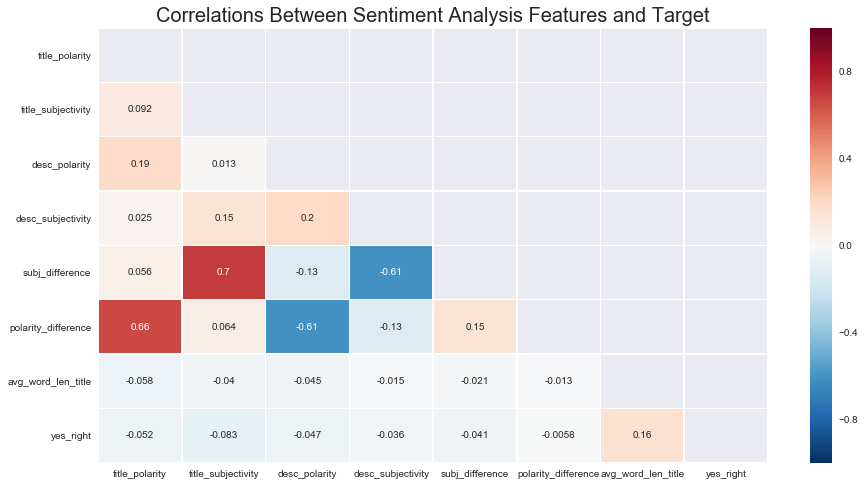

In [175]:
num_corrs = df[['title_polarity','title_subjectivity','desc_polarity',
                'desc_subjectivity', 'subj_difference','polarity_difference',
                'avg_word_len_title','yes_right']].corr()
mask = np.zeros_like(num_corrs, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(15,8))
plt.title('Correlations Between Sentiment Analysis Features and Target', fontsize=20)
sns.heatmap(num_corrs, linewidths=0.5, mask=mask, annot=True);
# Very insignificant 

In [180]:
# Looking at features based on target
rightwing = df[df.yes_right==1]
notrightwing = df[df.yes_right==0]

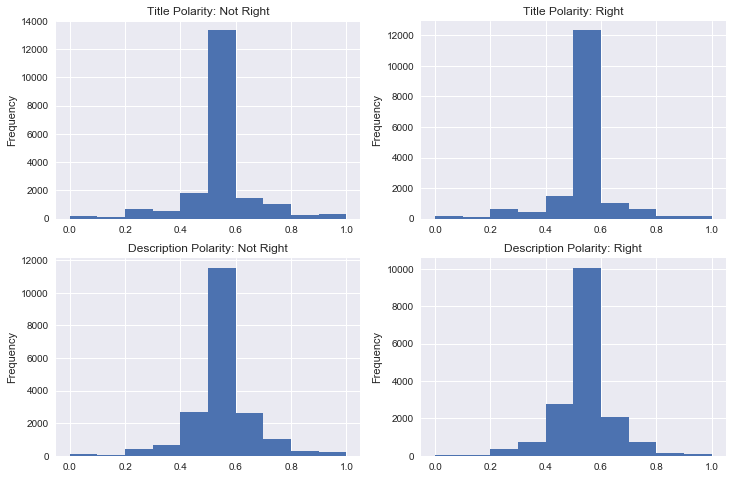

In [182]:
figure, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

rightwing.title_polarity.plot(kind='hist', ax=ax[0,1],
                              title='Title Polarity: Right')
notrightwing.title_polarity.plot(kind='hist', ax=ax[0,0],
                                 title='Title Polarity: Not Right')
notrightwing.desc_polarity.plot(kind='hist',
                                ax=ax[1,0], title='Description Polarity: Not Right')
rightwing.desc_polarity.plot(kind='hist',
                             ax=ax[1,1], title='Description Polarity: Right');

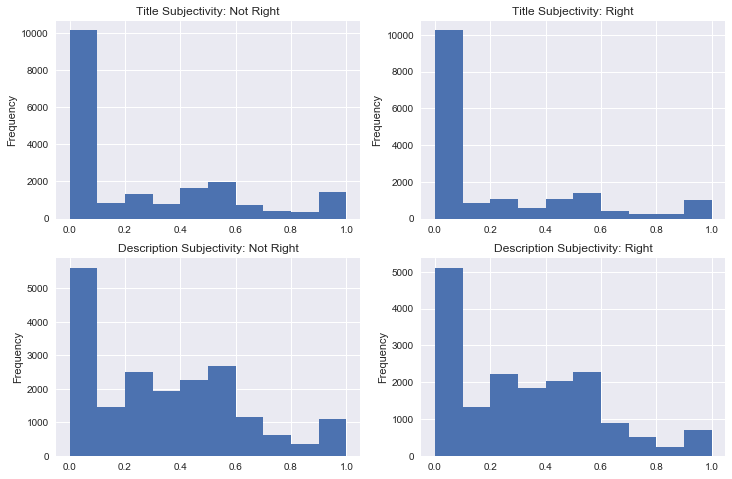

In [188]:
figure, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

rightwing.title_subjectivity.plot(kind='hist', ax=ax[0,1],
                                  title='Title Subjectivity: Right')
notrightwing.title_subjectivity.plot(kind='hist', ax=ax[0,0],
                                     title='Title Subjectivity: Not Right')
notrightwing.desc_subjectivity.plot(kind='hist', ax=ax[1,0],
                                    title='Description Subjectivity: Not Right')
rightwing.desc_subjectivity.plot(kind='hist', ax=ax[1,1],
                                 title='Description Subjectivity: Right');

In [185]:
rightwing.describe().T.head(7)

,count,mean,std,min,25%,50%,75%,max
title_polarity,17148.0,0.507856,0.113371,0.0,0.500000,0.500000,0.500000,1.000000
title_subjectivity,17148.0,0.201348,0.296501,0.0,0.000000,0.000000,0.400000,1.000000
desc_polarity,17148.0,0.524758,0.107297,0.0,0.500000,0.500000,0.568182,1.000000
desc_subjectivity,17148.0,0.312783,0.270642,0.0,0.000000,0.300000,0.500000,1.000000
subj_difference,17148.0,0.444283,0.180273,0.0,0.325000,0.478975,0.500000,1.000000
polarity_difference,17148.0,0.517420,0.070813,0.0,0.488722,0.526316,0.539474,1.000000
avg_word_len_title,17148.0,0.299787,0.065313,0.0,0.257143,0.294643,0.337662,0.714286


In [187]:
notrightwing.describe().T.head(7)

,count,mean,std,min,25%,50%,75%,max
title_polarity,19706.0,0.520245,0.124798,0.000000,0.500000,0.500000,0.550000,1.000000
title_subjectivity,19706.0,0.252814,0.315929,0.000000,0.000000,0.050000,0.487500,1.000000
desc_polarity,19706.0,0.535423,0.117463,0.000000,0.500000,0.500000,0.587500,1.000000
desc_subjectivity,19706.0,0.332736,0.284196,0.000000,0.000000,0.316369,0.500000,1.000000
subj_difference,19706.0,0.460039,0.200754,0.000000,0.325000,0.479167,0.555556,1.000000
polarity_difference,19706.0,0.518327,0.083516,0.052632,0.479825,0.526316,0.552632,0.960526
avg_word_len_title,19706.0,0.279079,0.062686,0.057143,0.238095,0.274725,0.317460,1.000000


### Exploring Word Counts

In the following several sections, I used Count Vectorizer to find the highest count single-grams, bi-grams, tri-grams, and quad-grams in the titles and descriptions, sorted by both target classes. After initially looking at the counts and seeing a lot of source information and noise, I created a custom preprocessor that removes stop grams of noise and source information as well as lemmatize the text. I also created a custom group of stop words that contain source information and appended it to SciKitLearn’s list of English stop words, which I used in all of my Count Vectorizer and TfIdf models. The initial words counts demonstrated that there is much noise in the data, and TfIdf might be the best choice for a vectorizer as it will penalize terms that appear very frequently across documents. However, if some of these terms only appear frequently in only one unique source, I decided to remove them manually.  

There were a couple interesting interpretations, especially as the n-grams increased, but the most common n-grams in the documents were mostly similar between left and right until the tri-gram level, when noticeable differences began to form. 

**Set Up Vectorizer**

In [41]:
lemmatizer = WordNetLemmatizer()

def my_preprocessor(doc):
    stop_grams = ['national review','National Review','Fox News','Content Uploads',
                  'content uploads','fox news', 'Associated Press','associated press',
                  'Fox amp Friends','Rachel Maddow','Morning Joe','morning joe',
                  'Breitbart News', 'fast facts', 'Fast Facts','Fox &', 'Fox & Friends',
                  'Ali Velshi','Stephanie Ruhle','Raw video', '& Friends', 'Ari Melber',
                  'amp Friends', 'Content uploads', 'Geraldo Rivera']
    for stop in stop_grams:
        doc = doc.replace(stop,'')
    return lemmatizer.lemmatize(doc.lower())

In [42]:
cust_stop_words = ['CNN','cnn','amp','huffpost','fox','reuters','ap','vice','breitbart',
                   'nationalreview', 'www','msnbc','infowars', 'foxnews','Vice','Breitbart',
                   'National Review','Fox News','Reuters','Fast Facts','Infowars','Vice',
                   'MSNBC','www','AP','Huffpost','HuffPost','Maddow', '&']
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
original_stopwords = list(ENGLISH_STOP_WORDS)
cust_stop_words += original_stopwords

### Single Grams for Title

In [5]:
right = text['yes_right'] == 1
notright = text['yes_right'] == 0

In [6]:
# Separate title and description based on target class
right_title = text[right].title
right_desc = text[right].description
notright_title = text[notright].title
notright_desc = text[notright].description

In [31]:
stem = PorterStemmer()
lemmatizer = WordNetLemmatizer()

In [18]:
def get_top_grams(df_r, df_nr, n):
    cvec = CountVectorizer(preprocessor=my_preprocessor,
                           ngram_range=(n,n), stop_words=cust_stop_words, min_df=5)
    cvec.fit(df_r)
    word_counts = pd.DataFrame(cvec.transform(df_r).todense(),
                       columns=cvec.get_feature_names())
    counts = word_counts.sum(axis=0)
    counts = pd.DataFrame(counts.sort_values(ascending = False),columns=['right']).head(15)
    
    cvec = CountVectorizer(preprocessor=my_preprocessor,
                           ngram_range=(n,n), stop_words=cust_stop_words, min_df=5)
    cvec.fit(df_nr)
    word_counts2 = pd.DataFrame(cvec.transform(df_nr).todense(),
                         columns=cvec.get_feature_names())
    counts2 = word_counts2.sum(axis=0)
    counts2 = pd.DataFrame(counts2.sort_values(ascending = False),columns=['not right']).head(15)
    return counts, counts2

In [14]:
r

,right
trump,2981
report,569
north,523
korea,502
says,481
new,453
house,419
border,419
kim,397
summit,390


In [15]:
nr

,not right
trump,3872
new,1043
says,585
house,471
2018,430
north,414
korea,401
cohen,391
mueller,377
white,350


### Single Grams for Description

In [19]:
r, nr = get_top_grams(right_desc, notright_desc, 1)

In [20]:
r

,right
trump,3830
president,3216
new,1479
house,1214
said,1205
donald,1111
north,938
state,909
says,846
news,760


In [21]:
nr

,not right
trump,4756
president,2799
new,2052
donald,1374
said,1093
house,1039
says,840
people,831
discuss,777
white,768


### BiGrams for Title

In [22]:
r, nr = get_top_grams(right_title, notright_title, 2)

In [23]:
r

,right
north korea,417
donald trump,303
white house,230
kim jong,182
president trump,181
ig report,141
supreme court,129
trump kim,121
judicial activism,104
day liberal,104


In [24]:
nr

,not right
north korea,321
white house,247
michael cohen,196
kim jong,165
donald trump,160
stormy daniels,113
world cup,111
royal wedding,99
scott pruitt,98
president trump,96


### BiGrams for Description

In [25]:
r, nr = get_top_grams(right_desc, notright_desc, 2)

In [26]:
r # Seeing some noise here 

,right
president trump,1187
donald trump,1088
president donald,932
white house,621
new york,481
kim jong,474
north korea,473
year old,339
united states,314
north korean,313


In [27]:
nr

,not right
donald trump,1352
president trump,904
president donald,673
white house,640
new york,420
kim jong,414
michael cohen,405
trump administration,401
north korea,386
north korean,254


### TriGrams for Title

In [28]:
r, nr = get_top_grams(right_title, notright_title, 3)

In [29]:
r # Mentions of MS 13 Gang and "judicial activism"

,right
liberal judicial activism,104
day liberal judicial,104
north korea summit,75
trump kim summit,66
new york times,27
border patrol agents,26
south china sea,26
trump kim jong,23
judicial activism june,22
cartoons day march,21


In [30]:
nr
# Interesting: NYT is not one of my sources
# Mentions of Stormy Daniels and immigration policy

,not right
north korea summit,73
trump kim summit,37
family separation policy,29
trump tower meeting,28
quickly catch day,21
catch day news,21
trump legal team,21
trump north korea,20
iran nuclear deal,20
stormy daniels lawyer,19


### TriGrams for Description

In [31]:
r, nr = get_top_grams(right_desc, notright_desc, 3)

In [32]:
r # For some reason "content uploads" is still appearing. Source giveaway. 
# Also image noise data.

,right
president donald trump,926
wp com com,238
wp content uploads,238
com wp content,238
com com wp,238
content uploads 2018,233
jpg fit 1024,218
1024 2c597 ssl,216
fit 1024 2c597,216
dictator kim jong,125


In [33]:
nr

,not right
president donald trump,672
north korean leader,158
new york times,155
leader kim jong,149
korean leader kim,133
special counsel robert,125
counsel robert mueller,123
fbi director james,81
director james comey,81
joy reid panel,81


### QuadGrams for Title

In [34]:
r, nr = get_top_grams(right_title, notright_title, 4)

In [35]:
r
# Again, lost of "judicial activism" and MS 13 appears 

,right
day liberal judicial activism,104
liberal judicial activism june,22
liberal judicial activism march,20
liberal judicial activism february,19
liberal judicial activism april,19
things caught eye today,11
north korea kim jong,9
fashion notes melania trump,9
santa fe high school,7
new york attorney general,7


In [36]:
nr

,not right
quickly catch day news,21
santa fe high school,15
trump family separation policy,14
prince harry meghan markle,13
new albums heavy rotation,11
new shows netflix stream,10
watch hulu new week,10
watch amazon prime new,10
trump north korea summit,10
amazon prime new week,10


### QuadGrams for Description

In [37]:
r, nr = get_top_grams(right_desc, notright_desc, 4)

In [38]:
r
# Very noisy

,right
com wp content uploads,238
com com wp content,238
wp com com wp,238
wp content uploads 2018,233
fit 1024 2c597 ssl,216
jpg fit 1024 2c597,209
special counsel robert mueller,108
north korean dictator kim,94
korean dictator kim jong,94
north korean leader kim,91


In [39]:
nr
# Less noise, and what you'd expect to see. 
# The right wing noise is likely source giveaway that should be fixed

,not right
north korean leader kim,133
korean leader kim jong,132
special counsel robert mueller,123
fbi director james comey,81
joy reid panel discuss,74
attorney general jeff sessions,63
discuss political news day,56
matthews panel guests discuss,56
panel guests discuss political,56
guests discuss political news,56


### Wordclouds

These provide a nice, fun visualization of words found in right wing and not right wing title text. The larger the word the more it appears. 

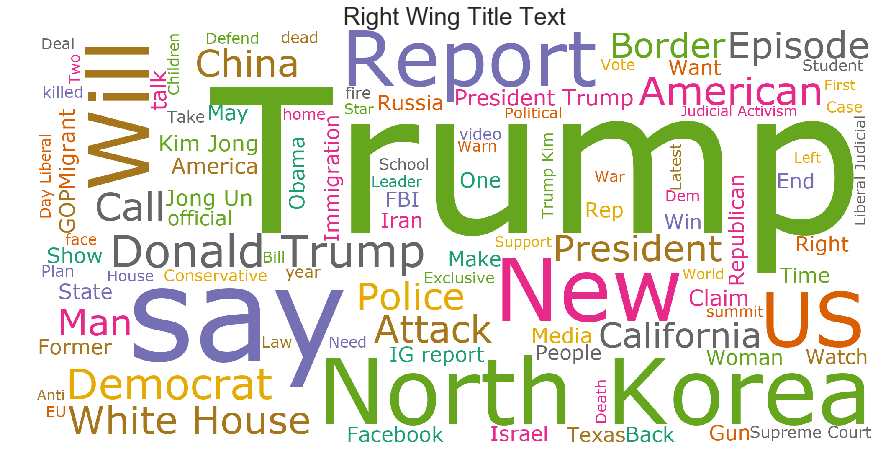

In [56]:
plt.figure(figsize=(15,8))
wordcloud = WordCloud(font_path='/Library/Fonts/Verdana.ttf',
                      max_words=(100),
                      width=2000, height=1000,
                      relative_scaling = 0.5,
                      background_color='white',
                      colormap='Dark2'
                  
).generate(' '.join(text[right].title))
plt.imshow(wordcloud)
plt.title("Right Wing Title Text", fontsize=24)
plt.axis("off")
plt.show()

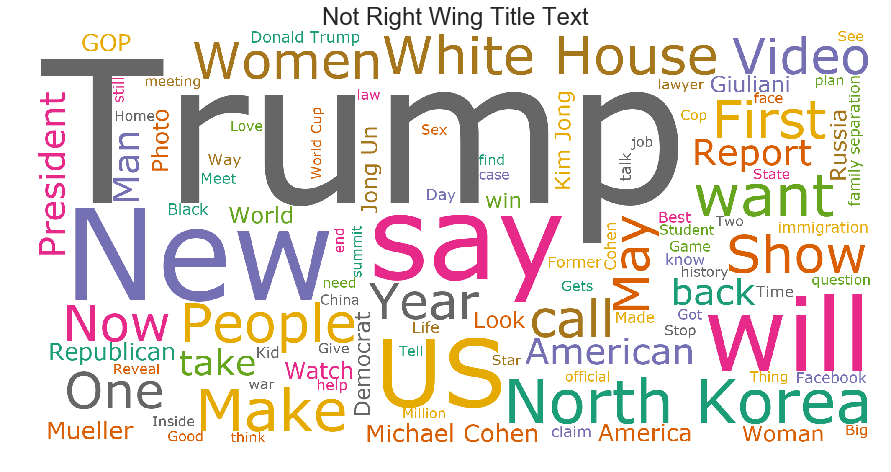

In [57]:
plt.figure(figsize=(15,8))
wordcloud = WordCloud(font_path='/Library/Fonts/Verdana.ttf',
                      max_words=(100),
                      width=2000, height=1000,
                      relative_scaling = 0.5,
                      background_color='white',
                      colormap='Dark2'
                  
).generate(' '.join(text[notright].title))
plt.imshow(wordcloud)
plt.title("Not Right Wing Title Text", fontsize=24)
plt.axis("off")
plt.show()

<a id="modeling"></a>
# Modeling
[Return to Index](#contents)

For modeling, I first looked at title and description only to evaluate feature importances, and then did the same for only the numerical features created with feature engineering. Unsurprisingly, the numerical features did not have a great accuracy score, but 65% is still 12% better than the baseline. With text data, TfIdf gave me a better score with around 75% accuracy, an improvement of 22% from the baseline. Given this, I am hoping a combination of both features in a Pipeline using FeatureUnion will improve my score upon that.

In [2]:
# Load in cleaned .csv files
text = pd.read_csv('./datasets/text2.csv').drop('Unnamed: 0', axis=1)
df = pd.read_csv('./datasets/df2.csv').drop('Unnamed: 0', axis=1)

<a id="text-only"></a>
### Text Features Only
#### Simple CountVec
[Return to Index](#contents)

In [58]:
# For text data only
X = text['combined']
y = text['yes_right']

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

In [45]:
cvec = CountVectorizer(preprocessor=my_preprocessor,
                       strip_accents='unicode',
                       ngram_range=(1,4),
                       stop_words=cust_stop_words,
                       min_df=5)

In [46]:
cvec.fit(X_train, y_train);

In [47]:
X_feats = pd.DataFrame(cvec.transform(X_train).todense(),
                       columns=cvec.get_feature_names()).sum(axis=0)

In [48]:
X_feats.sort_values(ascending = False).head(15)
# Most common n-grams

trump              11671
president           5052
new                 3763
house               2301
donald              2249
donald trump        2200
says                2080
north               1980
president trump     1803
said                1789
white               1612
korea               1497
kim                 1429
people              1420
news                1360
dtype: int64

In [60]:
cv_train = cvec.transform(X_train).todense()
cv_test = cvec.transform(X_test).todense()

In [61]:
lr = LogisticRegression(random_state=42)
lr.fit(cv_train, y_train);

In [62]:
lr.score(cv_train, y_train), lr.score(cv_test, y_test)

(0.96280752532561509, 0.76492294334708055)

In [88]:
cross_val_score(lr, cv_test, y_test, scoring='accuracy', cv=7).mean()

0.72845753667711011

In [89]:
print(classification_report(y_test, lr.predict(cv_test)))

             precision    recall  f1-score   support

          0       0.77      0.81      0.79      4927
          1       0.76      0.71      0.74      4287

avg / total       0.76      0.76      0.76      9214



In [91]:
print(confusion_matrix(y_test, lr.predict(cv_test)))
# Getting a lot of false positives.
# Model is predicting article is not right wing when it actually is

[[3982  945]
 [1223 3064]]


In [92]:
cfs = lr.coef_[0]
fts = cvec.get_feature_names()

In [93]:
pd.DataFrame(
    list(zip(fts, np.abs(cfs), cfs)),
    columns=['feat','abs','coef']).sort_values('abs',ascending=False).head(15)
# Still some noise to correct, but looking better than previous dead giveaways of source

,feat,abs,coef
10635,joins discuss,2.848528,-2.848528
7762,fmr,2.781032,-2.781032
5441,delingpole,2.498305,2.498305
13927,nolte,2.408937,2.408937
22395,visit post,2.293419,2.293419
2862,broadcast,2.266196,2.266196
21829,tucker,2.243125,2.243125
8433,goodnewsruhles,2.142707,-2.142707
20839,times local,2.113027,2.113027
10032,insight,2.103617,2.103617


**Passive Aggressive Classifier** on Same CountVectorized data:

In [94]:
pac = PassiveAggressiveClassifier(C=0.5, random_state=42)

In [95]:
pac.fit(cv_train, y_train)
pac.score(cv_train, y_train)

0.9154486251808972

In [96]:
pac.score(cv_test, y_test)

0.74701541133058391

In [97]:
cross_val_score(pac, cv_test, y_test, scoring='accuracy', cv=7).mean()

0.70696935242130721

### TfIdf Vectorizer

In [98]:
tf = TfidfVectorizer(strip_accents='unicode', preprocessor=my_preprocessor,
                     ngram_range=(2,4), stop_words=cust_stop_words, min_df=2)

In [99]:
tf.fit(X_train, y_train)
tf_train = tf.transform(X_train)
tf_test = tf.transform(X_test)

In [100]:
lr = LogisticRegression(random_state=42)
parameters = {
    'penalty': ['l2','l1'],
    'C': [1.0,0.6]}

grid = GridSearchCV(lr, parameters, scoring='accuracy')

In [101]:
grid.fit(tf_train, y_train)
grid.score(tf_train, y_train), grid.score(tf_test, y_test)

(0.92243125904486256, 0.73855003255914908)

In [102]:
grid.best_params_

{'C': 1.0, 'penalty': 'l2'}

In [103]:
print(classification_report(y_test, grid.predict(tf_test)))

             precision    recall  f1-score   support

          0       0.72      0.82      0.77      4927
          1       0.76      0.64      0.69      4287

avg / total       0.74      0.74      0.74      9214



In [105]:
print(confusion_matrix(y_test, grid.predict(tf_test)))
# More false positives but fewer false negatives

[[4064  863]
 [1546 2741]]


In [106]:
fts = tf.get_feature_names()
cfs = grid.best_estimator_.coef_[0]

pd.DataFrame(list(zip(fts, np.abs(cfs), cfs)),
             columns=['feat','abs','coef']).sort_values('abs',ascending=False).head(15)
# Much, much less noise than CountVectorizer

,feat,abs,coef
47483,michael cohen,4.370050,-4.370050
38742,joins discuss,4.056380,-4.056380
35238,ig report,3.414464,3.414464
77969,times local,3.195757,3.195757
76722,tel aviv,3.082122,3.082122
66101,rudy giuliani,3.045239,-3.045239
58979,president trump,3.043469,3.043469
31829,gun control,2.961285,2.961285
50591,need know,2.901651,-2.901651
57161,police say,2.885630,2.885630


In [107]:
text[text['combined'].str.contains('IG report')]['source'].unique()

array(['Breitbart', 'CNN', 'Fox News', 'National Review', 'Infowars',
       'MSNBC'], dtype=object)

<a id="numerical-only"></a>
### Look at Numerical Features Only
[Return to Index](#contents)

In [63]:
X = df[[col for col in df.columns if col != 'yes_right']]
y = df['yes_right']

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

In [65]:
pipe = Pipeline([
#     ('poly', PolynomialFeatures(interaction_only=True)),
    ('model', LogisticRegression())
])

pipe.fit(X_train, y_train);

In [66]:
pipe.score(X_train, y_train), pipe.score(X_test, y_test)

(0.6296671490593343, 0.63338398089863257)

In [67]:
pd.DataFrame(list(zip(list(pipe.steps[0][1].coef_[0]),
                      np.abs(list(pipe.steps[0][1].coef_[0])), X.columns)), 
             columns=['coef','coef_abs','feat']).sort_values('coef_abs', ascending=False).head(10)

,coef,coef_abs,feat
24,-3.542671,3.542671,PRP$_title
55,3.161655,3.161655,NNPS_desc
42,-3.045602,3.045602,CC_desc
6,2.939313,2.939313,avg_word_len_title
43,2.722251,2.722251,CD_desc
59,-2.410286,2.410286,PRP_desc
60,-2.396420,2.396420,PRP$_desc
71,1.986782,1.986782,VBN_desc
77,-1.864823,1.864823,WRB_desc
44,-1.799065,1.799065,DT_desc


Again, for reference, part of speech tag descriptions can be found [here](https://www.clips.uantwerpen.be/pages/mbsp-tags). PRP$ is possessive pronoun, NNPS is plural proper noun, and CC is conjunction.

It is interesting to note that using a possessive pronoun has a negative correlation with being right wing. This includes plural possessive pronouns, such as in "*Our* Revolution".

<a id="pipeline"></a>
# Pipeline (Combining Text and Numerical Features)
[Return to Index](#contents)

In the Pipeline, four different models gave me around the same best accuracy scores: Passive Aggressive Classifier, Stochastic Gradient Descent Classifier, Logistic Regression, and Multinomial Naive Bayes Classifier. I decided to stick with Passive Aggressive Classifier as it had a slight edge on the others (not just because I love the name). There were a lot of different parameters to tune, in the model as well as in the Vectorizer, and I could spend a lot more time playing with this.

In [68]:
# For Pipeline:
X = pd.concat([text['combined'], df[[col for col in df.columns if col != 'yes_right']]], axis=1)
y = df['yes_right']
num_cols = [col for col in X.columns if col != 'combined']

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

In [70]:
# Function for FeatureUnion to extract data
class DfExtract(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        if len(self.column) > 1:
            return pd.DataFrame(X[self.column])
        else:
            return pd.Series(X[self.column[0]]) 
    def get_feature_names(self):
        return X.columns.tolist()

In [71]:
text_pipe = Pipeline([
            ('ext', DfExtract(['combined'])),
            ('tf', TfidfVectorizer(preprocessor=my_preprocessor,
                                   strip_accents='unicode',
                                   stop_words=cust_stop_words, min_df=2,
                                   ngram_range=(2,4), use_idf=True, binary=False)
            ),
#             ('lda', TruncatedSVD(n_components=500))
        ])

num_pipe = Pipeline([
            ('ext', DfExtract(num_cols)),
#             ('poly', PolynomialFeatures(interaction_only=True))
            ])

In [72]:
feat_union = FeatureUnion([('text', text_pipe),('numerical', num_pipe)],
                          transformer_weights={'text': 2, 'numerical': 1})

In [73]:
pipe = Pipeline([
    ('features', feat_union),
#     ('lda', TruncatedSVD(n_components=100)),
#     ('lr', LogisticRegression(random_state=42)),
    ('pac', PassiveAggressiveClassifier(fit_intercept=True, random_state=42))
#     ('mnb', MultinomialNB())
#     ('sgdc', SGDClassifier(random_state=42))
])

In [74]:
params = {
#     'lr__penalty': ['l1','l2'],
#     'lr__C': [0.33, 0.5, 0.75, 1.0],
    'pac__C': [0.25, 0.35, 0.45, 0.5, 0.65, 1],
    'pac__loss': ['hinge','squared_hinge'],
    'pac__average': [True, False]
#     'mnb__alpha': [0.001, 0.01, 0.025, 0.05, 0.1, 0.15, 0.2, 0.25]
#     'sgdc__loss': ['log','perceptron'],
#     'sgdc__penalty': ['l2','elasticnet'],
#     'sgdc__alpha': [0.00001, 0.0001, 0.001]
}

gs = GridSearchCV(pipe, params, scoring='accuracy')

In [75]:
gs.fit(X_train, y_train);

In [76]:
gs.score(X_train, y_train)

0.98133140376266281

In [77]:
gs.score(X_test, y_test)

0.75189928369871939

In [78]:
gs.best_params_

{'pac__C': 0.25, 'pac__average': True, 'pac__loss': 'hinge'}

<a id="eval-model"></a>
# Evaluate Model
[Return to Index](#contents)

Evaluating the first models that looked at text data and numerical data separately, it is clear that TfIdf Vectorizer did its job. The inverse document frequency weighting factor greatly reduced the amount of noise in the strongest coefficients compared to the Count Vectorizer model. Furthermore, as accuracy increased with TfIdf, the amount of false positives increased and false negatives increased. The recall score for the positive class was only 64%. This makes sense as there are several thousand more not right wing sources than right wing sources. I hoped that I could account for this in the Pipeline model that balances text data with numerical data.

In the main Pipeline model, the 75.2% accuracy score isn’t as good as I had hoped for, but it is important to note that this score declined significantly the more I evaluated the model results and appropriately cleaned the data more, reducing noise and source giveaways. This helped to reduce overfitting; previously the train set score was a perfect 1.0. After cleaning the data more, the model will likely perform better on other political news media text outside of the data I have collected. For example, “Fast Facts” was previously a bi-gram with a very strong negative coefficient. This ended up being a giveaway for CNN. Removing it didn’t help my accuracy score, but improved the general performance of the model as it is intended to function.

Furthermore, compared to the models I ran on the text data and numerical data separately, the Pipeline using the Passive Aggressive Classifier accounted for the previous issue of having many false positives. Accuracy, recall, precision, and F1 scores were all 75%, as there were about the same about of false positives as false negatives. Although there are no ethical considerations to consider when classifying political text—misclassifying a right wing article as not right wing isn’t any better or worse than misclassifying a not right wing article as right wing—it is an indication that the model is performing better overall when the errors are more balanced because the classes are slightly unbalanced in favor of not right wing sources. 

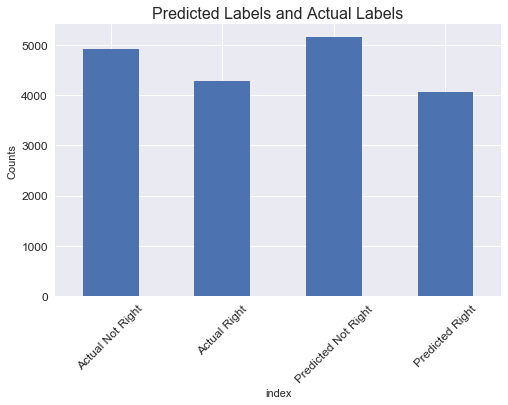

In [125]:
y_counts = pd.DataFrame(y_test)['yes_right'].value_counts()
yhat_counts = pd.DataFrame(gs.predict(X_test))[0].value_counts()
pred_df = pd.DataFrame(pd.concat([y_counts, yhat_counts], axis=0))
pred_df['index']=['Actual Not Right','Actual Right','Predicted Not Right', 'Predicted Right']
pred_df.set_index('index', inplace=True)
pred_df.plot(kind='bar', rot=45, fontsize=12, figsize=(8,5), legend=False, use_index=True)
plt.title("Predicted Labels and Actual Labels", fontsize=16)
plt.ylabel('Counts');

In [126]:
print(classification_report(y_test, gs.predict(X_test)))

             precision    recall  f1-score   support

          0       0.76      0.79      0.77      4927
          1       0.75      0.71      0.73      4287

avg / total       0.75      0.75      0.75      9214



In [127]:
import itertools
# From ScikitLearn's documentation:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[3896 1031]
 [1255 3032]]


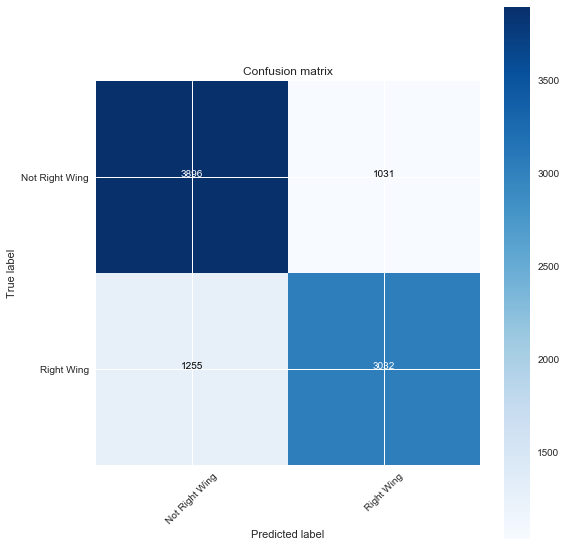

In [128]:
np.set_printoptions(precision=2)
plt.figure(figsize=(8,8))
plot_confusion_matrix(confusion_matrix(y_test, gs.predict(X_test)), classes=['Not Right Wing','Right Wing'],
                      title='Confusion matrix')
plt.show()

In [84]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_test, y_hat)

0.74899968274858175

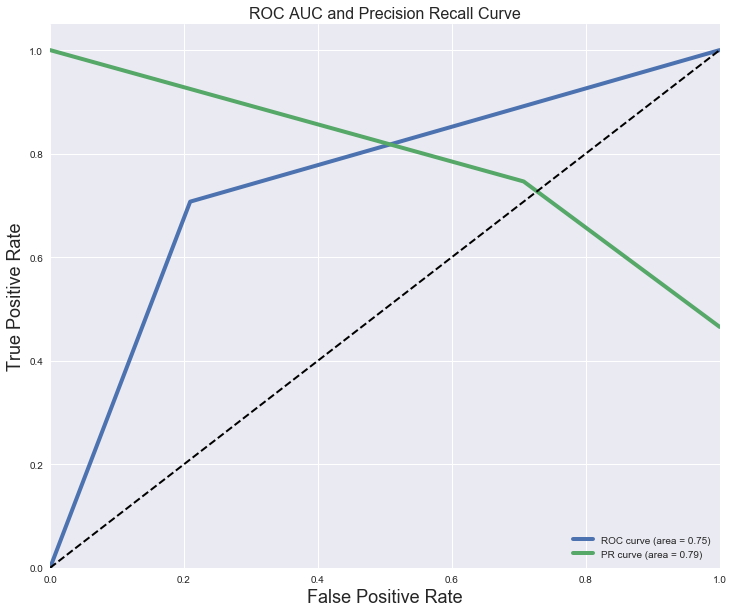

In [85]:
# ROC AUC Curve looks a bit silly without predict_proba
y_hat = gs.predict(X_test) # Model's predictions

# For class 1, find the area under the curve
false_pos, true_pos, _ = roc_curve(y_test, y_hat)
ROC_AUC = auc(false_pos, true_pos)
prec, rec, _ = precision_recall_curve(y_test, y_hat)
PR_AUC = auc(rec, prec)

# Plot of a ROC curve for class 1 (has_cancer)
plt.figure(figsize=[12,10])
plt.plot(false_pos, true_pos, label='ROC curve (area = %0.2f)' % ROC_AUC, linewidth=4)
plt.plot(rec, prec, label='PR curve (area = %0.2f)' % PR_AUC, linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('ROC AUC and Precision Recall Curve', fontsize=16)
plt.legend(loc="lower right")
plt.show()

#### How well does the model work for each news source?
Make function with input source name, or for loop through `source.unique()`

In [129]:
# Will work on this function when I have time

<a id="answer-question"></a>
# Interpret Results
[Return to Index](#contents)

Interpreting this model has become less and less challenging the more the data has been appropriately cleaned. However, by looking at the strongest coefficients, it is clear there is still some work to do. “Geraldo Rivera” had not appeared in the top strongest coefficients until the most recent iteration of running the model. However, we are starting to see some n-grams that make sense, such as “far left anti” being correlated with right wing articles. As this model continues to be tuned, it will provide more insight into what kind of language is used differently based on the kind of news source the language is found in. A high amount of possessive pronouns in the article title has a strong correlation with being not right wing, for example. Furthermore, the word cloud displays words ignored by the model because they either occurred in too many documents, occurred in to few documents, or were cut off by feature selection. It is what you’d expect to see, but a fun graphic nevertheless. 

### Getting Feature Importances

In [130]:
feature_names = text_pipe.fit(X_train, y_train).steps[1][1].get_feature_names()
feature_names.extend(num_pipe.fit(X_train, y_train).steps[0][1].get_feature_names())

In [131]:
pipe_coefs = list(gs.best_estimator_.steps[1][1].coef_[0])

In [134]:
feature_names.remove(feature_names[0])

In [135]:
importances = pd.DataFrame(list(zip(feature_names, pipe_coefs, np.abs(pipe_coefs))),
                          columns=['feature','coef','abs_coef'])

In [136]:
importances.sort_values('abs_coef', ascending=False).head(15)

,feature,coef,abs_coef
38742,joins discuss allegations,-2.571948,2.571948
77969,times local 05,2.363979,2.363979
88213,PRP$_title,-2.002159,2.002159
51782,news news brexit,1.943806,1.943806
26515,far left anti,1.763821,1.763821
36243,ingraham angle discuss,1.763778,1.763778
35238,ig report calls,1.721798,1.721798
54632,panel discusses latest,-1.691897,1.691897
43058,left wing activist,1.686019,1.686019
13061,charles krauthammer beloved,1.656056,1.656056


In [137]:
text[text['combined'].str.contains('Visits White')]['source'].unique()

array(['National Review'], dtype=object)

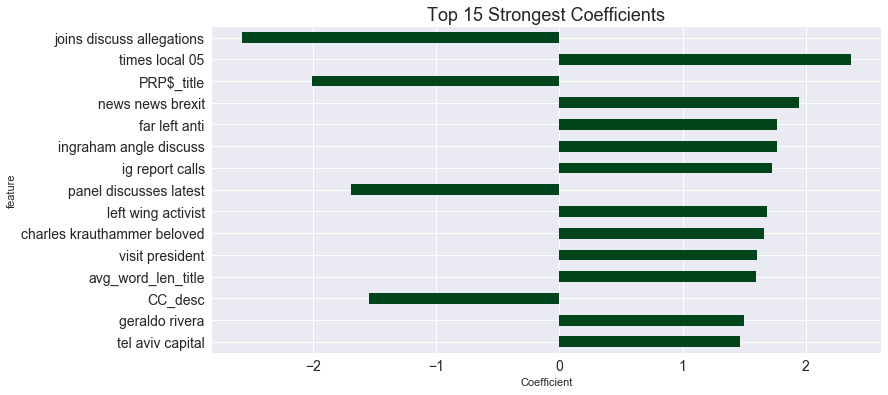

In [140]:
# PRP$_title means possesive pronoun in title, CC_desc is conjunction in description 
feat_imports = importances.sort_values('abs_coef', ascending=True).tail(15)
feat_imports['sign'] = feat_imports['coef'].map(lambda x: 'Negative' if x < 0 else 'Positive')
feat_imports.set_index('feature', inplace=True)

feat_imports['coef'].plot(kind='barh', figsize=(12,6),
                  title='Strongest Coefficients (Absolute Value)',
                  fontsize=14, legend=False, cmap='Greens_r')
plt.xlabel('Coefficient')
plt.title('Top 15 Strongest Coefficients', fontsize=18);

In [149]:
# Plot words ignored by model
text_pipe.fit(X_train, y_train)
ignored_text = text_pipe.steps[1][1].stop_words_

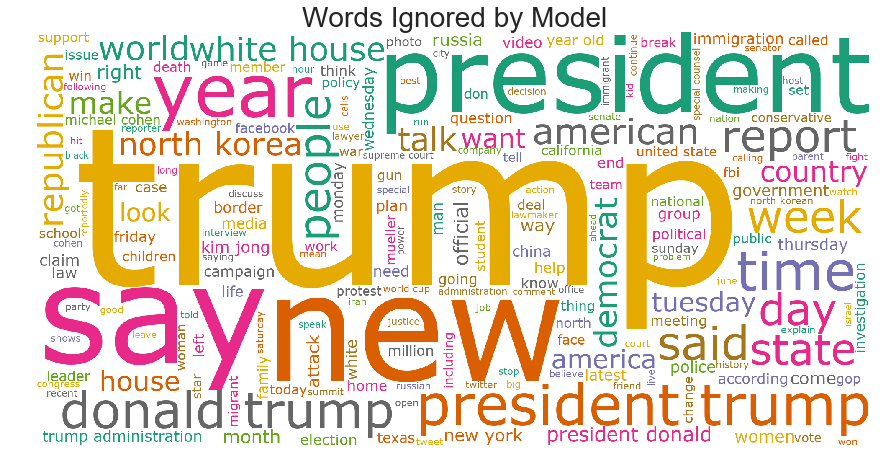

In [156]:
plt.figure(figsize=(15,8))
wordcloud = WordCloud(font_path='/Library/Fonts/Verdana.ttf',
                      width=2000, height=1000,
                      relative_scaling = 1.0,
                      background_color='white',
                      colormap='Dark2'
                  
).generate(' '.join(ignored_text))
plt.imshow(wordcloud)
plt.title("Words Ignored by Model", fontsize=28)
plt.axis("off")
plt.show()

----------------------------------------------------------------------------

In [34]:
# I will have to change this for feat union and make function that creates NLP features
def manual_test():
    title = input('Article title: \n')
    desc = input('Article description: \n')
    df = [{'title': '{}'.format(title),
                'description': '{}'.format(desc)
                }]
    df=pd.DataFrame(df)
    pred = gs.predict(df)
    if pred == 1:
        print("Result: Right wing")
    else:
        print("Result: Not right wing")

In [35]:
manual_test()

Article title: 
Wait until midterms to choose next Supreme Court justice
Article description: 
Mitch Mcconnell set a bad precedent 
Result: Not right wing


<a id="next-steps"></a>
# Next Steps
[Return to Index](#contents)

There is clearly a lot of work that can be done with this project to improve on it. Given that the data is fairly time-specific, I would like to gather more article data from other time periods, both from the past and in the future. I would also like to continue creating more features from the text using other NLP tools. Nevertheless, it was a fun project to see what I could do with this dataset, and the project can function as a springboard to more bigger and complex NLP projects. This project was a very enjoyable learning experience to work on and will certainly continue to be as I keep playing with it.